### GCN代码复现

**参考资料：**

* [整体框架的代码参考与相关解释](https://zhuanlan.zhihu.com/p/78191258)
* [代码优化部分的参考](https://blog.csdn.net/qq_41845951/article/details/120874708)
* [可视化参考](https://blog.csdn.net/weixin_50706330/article/details/127504596)

In [120]:
import numpy as np
import scipy.sparse as sp
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [121]:
## 标签独热编码
def encode_onehot(labels):
    classes = set(labels)
    # print('classes:',classes)
    class_dict = {c: np.identity(len(classes))[i, :] for i, c in enumerate(classes)}
    # print('class_dict:',class_dict)
    
    label_onehot = np.array(list(map(class_dict.get, labels)),
                           dtype=np.int32)
                           
    # print('label_onehot:',label_onehot.shape)
    
    return label_onehot

In [122]:
# label和矩阵归一化
def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    
    return mx

![formula](./picture/Convolution_formula.jpg "formula")

In [123]:
from torch_geometric.utils import add_self_loops, degree
# 矩阵归一化(优化公式)
def normalize11(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    # print(shape[0])
    row, col = indices
    # print(row, col)
    deg = degree(col, shape[0])
    deg_inv_sqrt = deg.pow(-0.5)
    norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
    values = norm * values
  
    # return indices, values, shape
    return torch.sparse.FloatTensor(indices, values, shape)

In [124]:
# test
adj1 = sp.csr_matrix([[1,1,0,0],[1,1,1,1],[0,1,1,1],[0,1,1,1]])
adj1.todense()

matrix([[1, 1, 0, 0],
        [1, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 1, 1]], dtype=int32)

In [125]:
def accuracy(output, labels):
    pred = output.max(1)[1].type_as(labels)
    correct = pred.eq(labels).double()
    correct = correct.sum()
    
    return correct / len(labels)

In [126]:
# 稀疏矩阵优化
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
    np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    
    return torch.sparse.FloatTensor(indices, values, shape)

## cora数据集介绍

###  文件构成
cora数据集包含了机器学习相关的论文，论文的类别有七种，分别是：

* Case_Based
* Genetic_Algorithms
* Neural_Networks
* Probabilistic_Methods
* Reinforcement_Learning
* Rule_Learning
* Theory

cora数据集共包含两个文件。其中:

.content文件的每一行代表一篇论文，每行的组织形式是：**<paper_id> <word_attributes> <class_label>**。word_attributes是维度为1433的one-hot向量，class_label是上述七种类型的一种。

.cites文件记录了论文之间的引用关系。文件的每一行代表

In [127]:
## 数据加载
def load_data(path="./cora/", dataset="cora"):
    print("Loading data...")
    
    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32) # 按行压缩的稀疏矩阵
    labels = encode_onehot(idx_features_labels[:, -1])
    
    # build graph
    # 处理节点
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    # 处理边
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)                  
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32,
                    ).reshape(edges_unordered.shape)
    # 构造邻接矩阵
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                       shape=(labels.shape[0], labels.shape[0]),
                       dtype=np.float32) # 构建有向邻接矩阵
    
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj) # 转换成无向图的邻接矩阵需要扩充成对称矩阵。
    
    # 处理特征和邻接矩阵
    features = normalize(features)
    adj = normalize11(adj + sp.eye(adj.shape[0])) # 加上单位矩阵，然后标准化
    
    idx_train = range(1000)
    idx_val = range(1000, 1500)
    idx_test = range(1500, 2500)
    
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    
    # adj = sparse_mx_to_torch_sparse_tensor(adj)
    
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    print("数据加载成功...")
    
    return adj, features, labels, idx_train, idx_val, idx_test

In [128]:
adj, features, labels, idx_train, idx_val, idx_test =load_data()


Loading data...
数据加载成功...


In [129]:
adj

tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [   0,    8,   14,  ..., 1389, 2344, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0913,  ..., 0.2236, 0.3536, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)

In [130]:
features.shape

torch.Size([2708, 1433])

In [131]:
labels

tensor([5, 1, 2,  ..., 3, 0, 5])

In [132]:
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.use_bias = bias
        if self.use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        self.reset_parameters()
        
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight)
        if self.use_bias:
            nn.init.zeros_(self.bias)
    
    def forward(self, input_features, adj):
        support = torch.mm(input_features, self.weight)
        output = torch.spmm(adj, support)
        if self.use_bias:
            return output + self.bias
        else:
            return output

![model](./picture/model.jpg "model")

In [133]:
class GCN(nn.Module):
    def __init__(self, input_dim=1433):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_dim, 16)
        self.gcn2 = GraphConvolution(16, 7)
        pass
    
    def forward(self, X, adj):
        X = F.relu(self.gcn1(X, adj))
        X = F.dropout(X, p=0.02, training=self.training)
        X = self.gcn2(X, adj)
        
        return F.log_softmax(X, dim=1)

In [134]:
model = GCN(features.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [135]:
def train(epochs):

    loss_history = []
    val_acc_history = []
    model.train()
    
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(features, adj)
        loss_train = F.nll_loss(output[idx_train], labels[idx_train])
        acc_train = accuracy(output[idx_train], labels[idx_train])
        loss_train.backward()
        optimizer.step()

        loss_val = F.nll_loss(output[idx_val], labels[idx_val])
        acc_val = accuracy(output[idx_val], labels[idx_val])
        
         # 记录训练过程中损失值和准确率的变化，用于画图
        loss_history.append(loss_train.item())
        val_acc_history.append(acc_val.item())

        if (epoch % 10 == 0):
            print("Epoch: {}".format(epoch + 1),
                 "loss_train: {:.4f}".format(loss_train.item()),
                 "acc_train: {:.4f}".format(acc_train.item()),
                 "loss_val: {:.4f}".format(loss_val.item()),
                 "acc_val: {:.4f}".format(acc_val.item()))
    return loss_history, val_acc_history


In [136]:
loss_history, val_acc_history = train(401)

Epoch: 1

 loss_train: 1.9507 acc_train: 0.0800 loss_val: 1.9518 acc_val: 0.0860
Epoch: 11 loss_train: 1.8108 acc_train: 0.3270 loss_val: 1.8329 acc_val: 0.2940
Epoch: 21 loss_train: 1.7118 acc_train: 0.3270 loss_val: 1.7742 acc_val: 0.2940
Epoch: 31 loss_train: 1.5999 acc_train: 0.3580 loss_val: 1.6891 acc_val: 0.2940
Epoch: 41 loss_train: 1.4538 acc_train: 0.4590 loss_val: 1.5593 acc_val: 0.3480
Epoch: 51 loss_train: 1.2868 acc_train: 0.6450 loss_val: 1.4196 acc_val: 0.5260
Epoch: 61 loss_train: 1.1134 acc_train: 0.7760 loss_val: 1.2674 acc_val: 0.6980
Epoch: 71 loss_train: 0.9622 acc_train: 0.8240 loss_val: 1.1159 acc_val: 0.7660
Epoch: 81 loss_train: 0.8325 acc_train: 0.8450 loss_val: 0.9899 acc_val: 0.7960
Epoch: 91 loss_train: 0.7379 acc_train: 0.8590 loss_val: 0.8875 acc_val: 0.8160
Epoch: 101 loss_train: 0.6608 acc_train: 0.8720 loss_val: 0.8114 acc_val: 0.8260
Epoch: 111 loss_train: 0.6041 acc_train: 0.8840 loss_val: 0.7583 acc_val: 0.8360
Epoch: 121 loss_train: 0.5592 acc_train: 0.8960

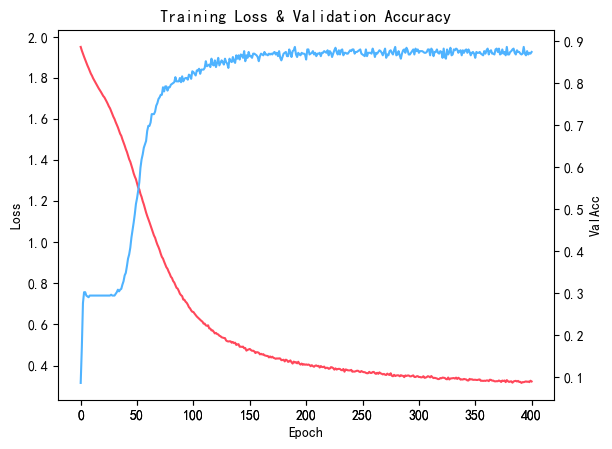

In [137]:
# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

def plot_loss_with_acc(loss_history, val_acc_history):
    fig = plt.figure()
    # 坐标系ax1画曲线1
    ax1 = fig.add_subplot(111)  # 指的是将plot界面分成1行1列，此子图占据从左到右从上到下的1位置
    ax1.plot(range(len(loss_history)), loss_history,
             c=np.array([255, 71, 90]) / 255.)  # c为颜色
    plt.ylabel('Loss')
    
    # 坐标系ax2画曲线2
    ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)  # 其本质就是添加坐标系，设置共享ax1的x轴，ax2背景透明
    ax2.plot(range(len(val_acc_history)), val_acc_history,
             c=np.array([79, 179, 255]) / 255.)
    ax2.yaxis.tick_right()  # 开启右边的y坐标
    
    ax2.yaxis.set_label_position("right")
    plt.ylabel('ValAcc')
    
    plt.xlabel('Epoch')
    plt.title('Training Loss & Validation Accuracy')
    plt.show()
 
plot_loss_with_acc(loss_history, val_acc_history)

In [138]:
# test    
def test():
    model.eval()
    
    with torch.no_grad():  # 显著减少显存占用
        output = model(features, adj)
        pred = output.max(1)[1].type_as(labels)
        loss_test = F.nll_loss(output[idx_test], labels[idx_test])
        acc_test = accuracy(output[idx_test], labels[idx_test])
        print("Test set results:",
            "loss= {:.4f}".format(loss_test.item()),
            "accuracy= {:.4f}".format(acc_test.item()))
    
    return output, pred

In [139]:
output, test_label = test()

Test set results: loss= 0.5893 accuracy= 0.8360


In [140]:
output.shape

torch.Size([2708, 7])

### 结果降维可视化

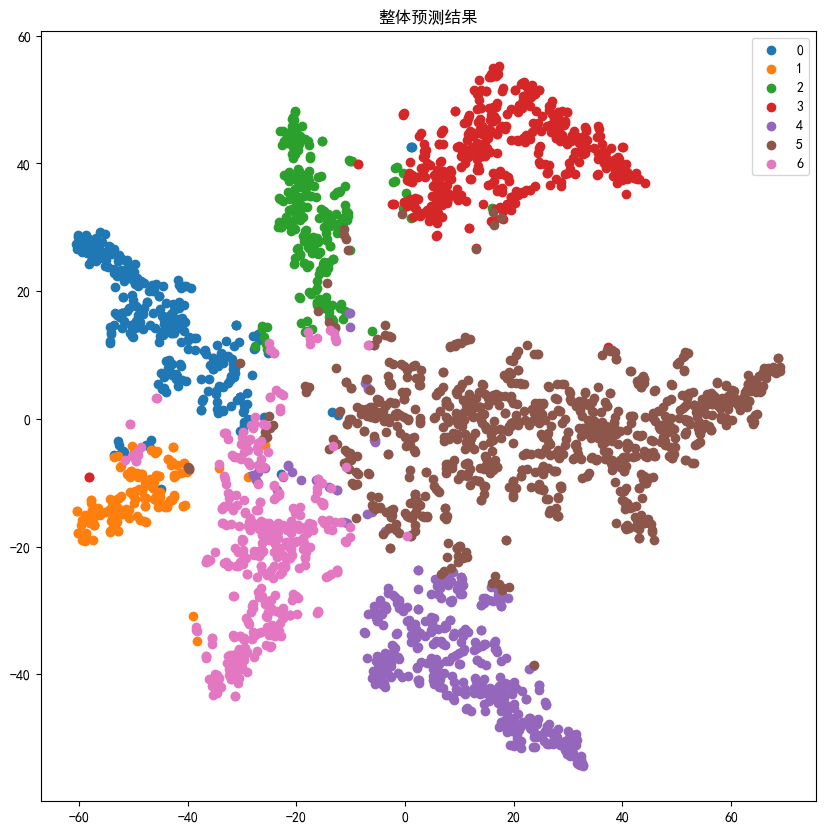

In [142]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
out = tsne.fit_transform(output)

plt.figure(figsize=(10,10))
for i in range(7):
    indices = test_label == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))
plt.title("整体预测结果")
plt.legend()
plt.show()

预测总数: 2708
预测成功数: 2376
预测失败数: 332
准确率: 0.8774002954209749


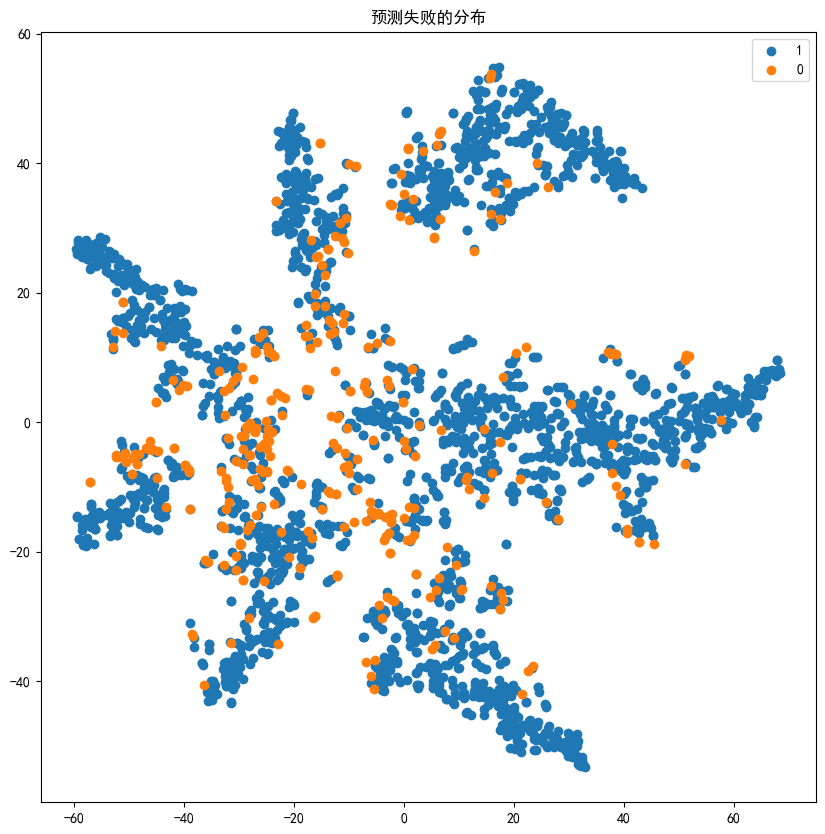

In [143]:
out = tsne.fit_transform(output)

plt.figure(figsize=(10,10))

indices = labels == test_label 
x, y = out[indices].T
plt.scatter(x, y, label=str(1))
print('预测总数:', len(indices))
print('预测成功数:', int(indices.sum()))

indices = labels != test_label 
x, y = out[indices].T
plt.scatter(x, y, label=str(0))
print('预测失败数:', int(indices.sum()))
print('准确率:', (len(indices)-int(indices.sum()))/len(indices))

plt.title("预测失败的分布")
plt.legend()
plt.show()

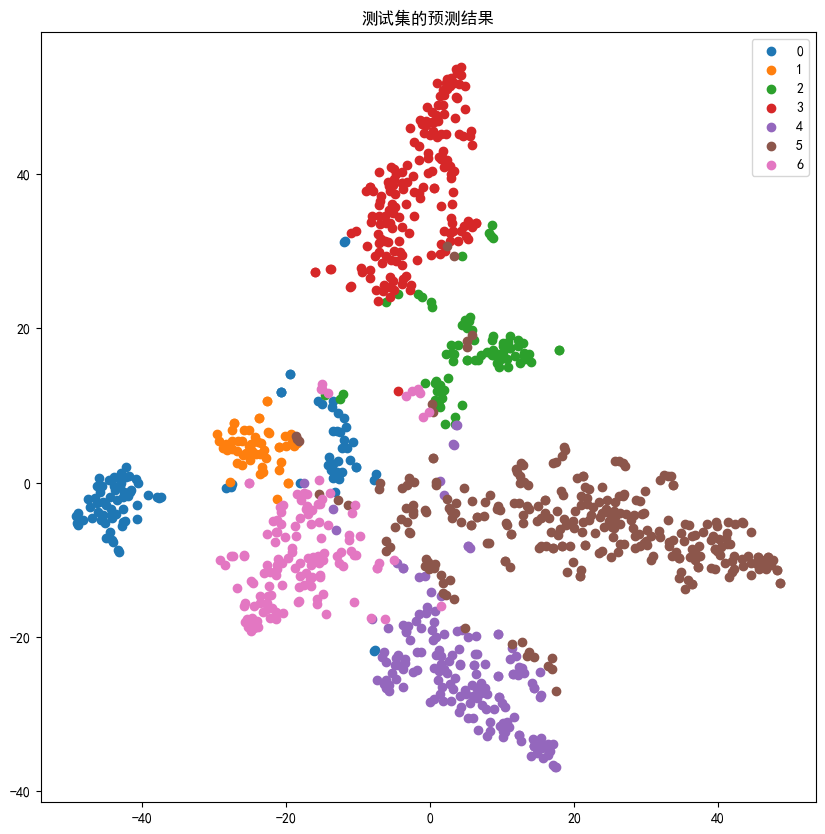

In [144]:
out = tsne.fit_transform(output[idx_test])

plt.figure(figsize=(10,10))
for i in range(7):
    indices = test_label[idx_test] == i
    x, y = out[indices].T
    plt.scatter(x, y, label=str(i))

plt.title("测试集的预测结果")
plt.legend()
plt.show()